In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import sklearn
from scipy.stats import randint
import os

pd.set_option('display.max_columns', None)
os.getcwd()

'c:\\Users\\parke\\data_work\\datascience\\machine_learning'

# Supermarket Classification 

## Import common Sklearn helper functions



In [3]:
# model selection, cross validation and hyperparam tuning
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV

# preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

# imputation
from sklearn.impute import SimpleImputer, KNNImputer

# pipelines
from sklearn.pipeline import make_pipeline

# custom transformers 
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

# dummy model for baseline comparison
from sklearn.dummy import DummyClassifier

# classificaion model metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve , roc_auc_score, f1_score, roc_curve 



## Dataset Import and basic look

In [4]:
df = pd.read_csv('superstore_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Check for NA

In [8]:
df.isna().sum()

Id                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64

### Check for duplicates

In [11]:
df.duplicated().sum()

0

In [5]:
df.columns = df.columns.str.lower()
# dropping dt_customer (only date feature) for now but will come abck to it
df = df.drop(columns=['id','dt_customer'], axis = 1)
df.head(10)

,year_birth,education,marital_status,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain
0,1970,Graduation,Divorced,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0
1,1961,Graduation,Single,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0
2,1958,Graduation,Married,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0
3,1967,Graduation,Together,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0
4,1989,Graduation,Single,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0
5,1958,PhD,Single,71691.0,0,0,0,336,130,411,240,32,43,1,4,7,5,2,1,0
6,1954,2n Cycle,Married,63564.0,0,0,0,769,80,252,15,34,65,1,10,10,7,6,1,0
7,1967,Graduation,Together,44931.0,0,1,0,78,0,11,0,0,7,1,2,1,3,5,0,0
8,1954,PhD,Married,65324.0,0,1,0,384,0,102,21,32,5,3,6,2,9,4,0,0
9,1954,PhD,Married,65324.0,0,1,0,384,0,102,21,32,5,3,6,2,9,4,0,0


In [54]:
df.describe()

,year_birth,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.149107,0.009375
std,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.356274,0.096391
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000
50%,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000
75%,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000
max,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000


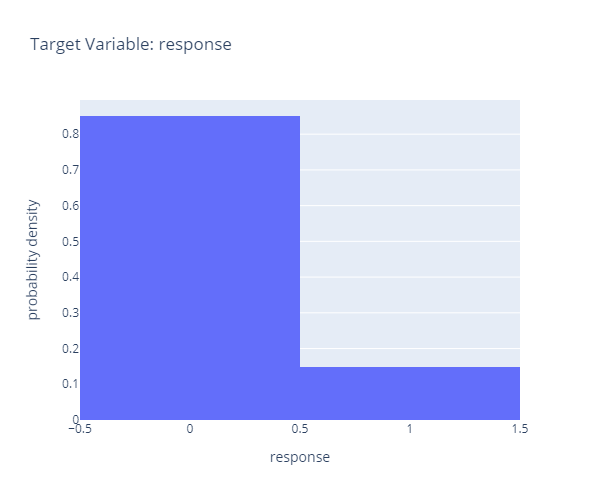

In [213]:
px.histogram(df, 
    x = 'response',
    histnorm='probability density',
    height = 500,
    width = 600,
    title = 'Target Variable: response').show('png')

## Split Data

In [6]:

def splitter(df, target, train_size, random_state):
    # Returns versions of test and train with and without the target for simple processing throughout the notebook
    train, test = train_test_split(df, train_size= train_size, random_state = random_state)

    X_train = train.drop(target, axis = 1).copy()
    y_train = train[target].copy()

    X_test = test.drop(target, axis = 1).copy()
    y_test = test[target].copy()

    return(train, test, X_train, X_test, y_train, y_test)


In [7]:
train, test, X_train, X_test, y_train, y_test = splitter(df, target = 'response', train_size = .8, random_state = 324)


## EDA on Training Set

In [16]:
train.head()

,year_birth,education,marital_status,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain
1356,1951,Graduation,Single,80872.0,0,0,60,483,72,567,94,12,108,1,4,4,10,1,0,0
629,1981,PhD,Married,87171.0,0,0,27,1001,44,107,58,44,44,1,6,7,11,2,0,0
402,1955,PhD,Together,75261.0,0,0,17,1239,17,413,23,34,17,1,5,6,5,2,1,0
1645,1965,Graduation,Married,44375.0,0,1,73,213,5,28,7,7,41,1,4,1,6,5,0,0
1801,1969,Master,Together,66476.0,0,1,80,742,28,152,25,9,57,2,6,8,10,4,0,0


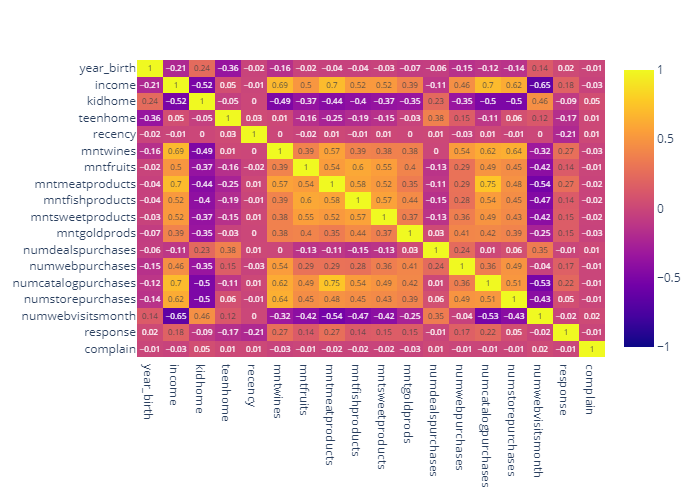

In [212]:
px.imshow(np.round(train.corr(),2),
    text_auto=True,
    aspect = 'auto',
    range_color = [-1,1]).show('png')

In [18]:
np.abs(train.corrwith(df["response"])).sort_values(ascending = False)


response               1.000000
mntmeatproducts        0.266204
mntwines               0.265862
numcatalogpurchases    0.223129
recency                0.207873
income                 0.183426
teenhome               0.165504
numwebpurchases        0.165416
mntsweetproducts       0.145993
mntgoldprods           0.145578
mntfishproducts        0.137259
mntfruits              0.136711
kidhome                0.085923
numstorepurchases      0.050393
numwebvisitsmonth      0.016074
year_birth             0.015557
complain               0.009311
numdealspurchases      0.007227
dtype: float64

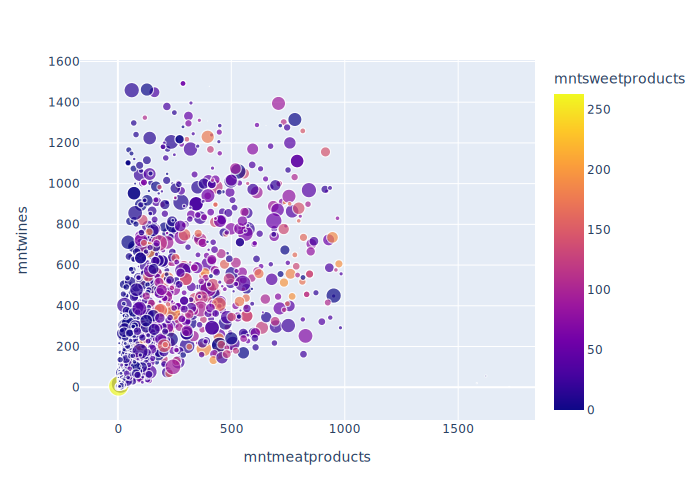

In [19]:
px.scatter(train,
    x = 'mntmeatproducts',
    y = 'mntwines',
    color = 'mntsweetproducts',
    size = 'mntgoldprods').show('svg')

### Exploring transformations for the highest correlated features to the target

In [20]:

# creates a list of the most highly correlated features to the target
cols_to_plot = np.abs(train.corrwith(df["response"])).sort_values(ascending = False).index[1:9].tolist()


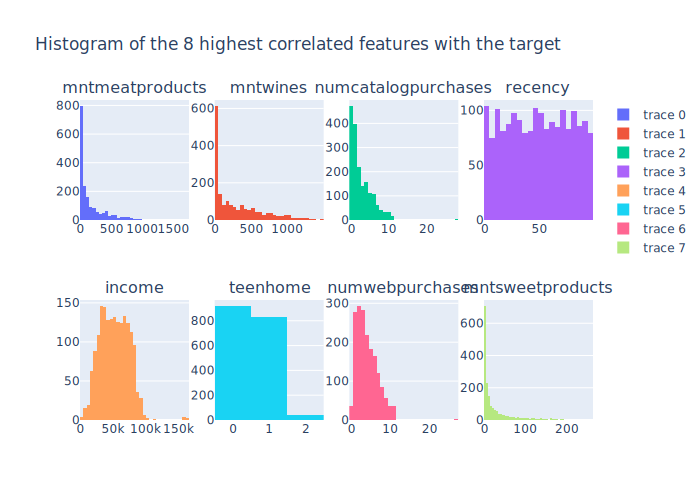

In [21]:

from plotly.subplots import make_subplots
import plotly.graph_objects as go


cols_to_plot = [('mntmeatproducts',1,1), 
    ('mntwines',1,2),
    ('numcatalogpurchases',1,3),
    ('recency',1,4),
    ('income',2,1), 
    ('teenhome',2,2), 
    ('numwebpurchases',2,3), 
    ('mntsweetproducts',2,4)]


fig  = make_subplots(rows = 2, 
    cols = 4,
    subplot_titles = ('mntmeatproducts', 'mntwines', 'numcatalogpurchases', 'recency', 'income', 'teenhome', 'numwebpurchases', 'mntsweetproducts')
)

for i,j,k in cols_to_plot:
    hist = go.Histogram(x = train[i])
    fig.append_trace(hist,j,k)

fig.update_layout(title_text = 'Histogram of the 8 highest correlated features with the target')
fig.show('svg')

- All the amount ('mnt') features appear to be strictly positive  and have right skew with moreate to heavy tails, log may be necessary
- income appears roughly normal - stand scalar prob fine
- recency looks roughly uniformly distributed  - stand scaler prob fine
- teen home looks pretty imbalanced - something to think about
- the number ('num') features are strictly positive but look confined to a somewhat narrow range minus some outliers - stand scaler may be fine for first pass

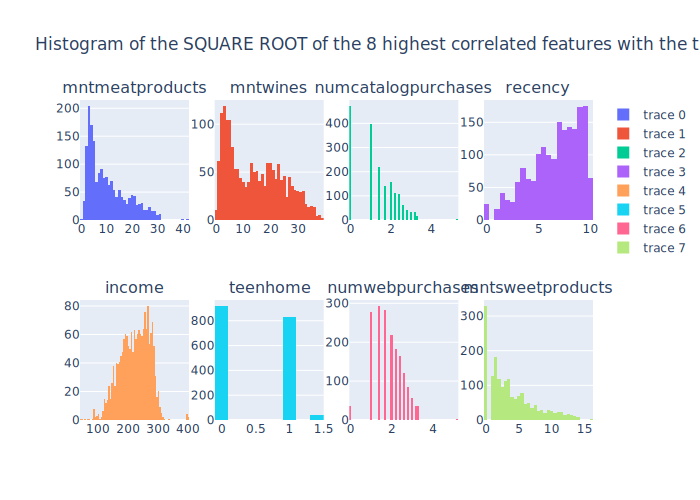

In [22]:
fig  = make_subplots(rows = 2, 
    cols = 4,
    subplot_titles = ('mntmeatproducts', 'mntwines', 'numcatalogpurchases', 'recency', 'income', 'teenhome', 'numwebpurchases', 'mntsweetproducts')
)

for i,j,k in cols_to_plot:
    hist = go.Histogram(x = np.sqrt(train[i]))
    fig.append_trace(hist,j,k)

fig.update_layout(title_text = 'Histogram of the SQUARE ROOT of the 8 highest correlated features with the target')
fig.show('svg')

- square root transformation does not appear to help any of the top features reach normality

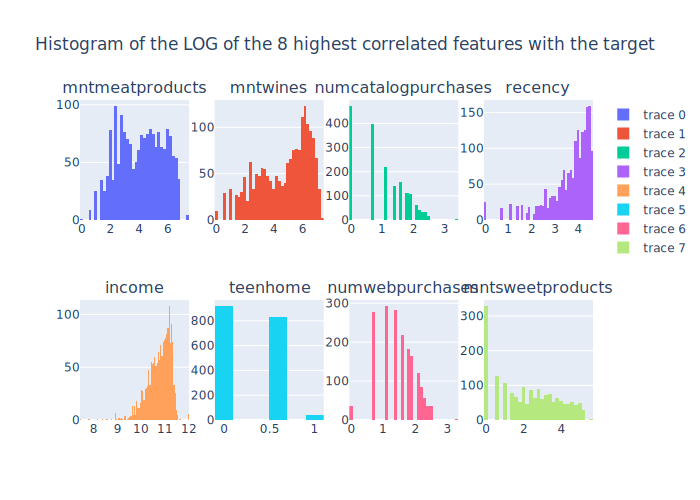

In [23]:
fig  = make_subplots(rows = 2, 
    cols = 4,
    subplot_titles = ('mntmeatproducts', 'mntwines', 'numcatalogpurchases', 'recency', 'income', 'teenhome', 'numwebpurchases', 'mntsweetproducts')
)

for i,j,k in cols_to_plot:
    hist = go.Histogram(x = np.log1p(train[i]))
    fig.append_trace(hist,j,k)

fig.update_layout(title_text = 'Histogram of the LOG of the 8 highest correlated features with the target')
fig.show('svg')

- log (1 + )transform appears to be reasonably appropriate for amount ('mnt) features

### How does the categorical data correlate with the respones?

In [24]:
train.groupby('education')['response'].mean()

education
2n Cycle      0.106918
Basic         0.048780
Graduation    0.139845
Master        0.151316
PhD           0.209302
Name: response, dtype: float64

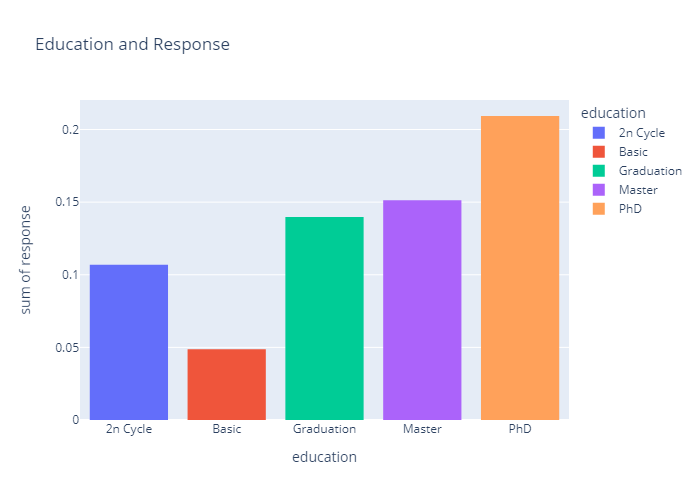

In [210]:
px.histogram(train.groupby('education').mean().reset_index(),
    x = 'education',
    y = 'response',
    color = 'education',
    title= 'Education and Response',
    labels= {'sum of response': "Response Rate by Group"}
    ).show('png')

In [26]:
train['education'].value_counts()

Graduation    901
PhD           387
Master        304
2n Cycle      159
Basic          41
Name: education, dtype: int64

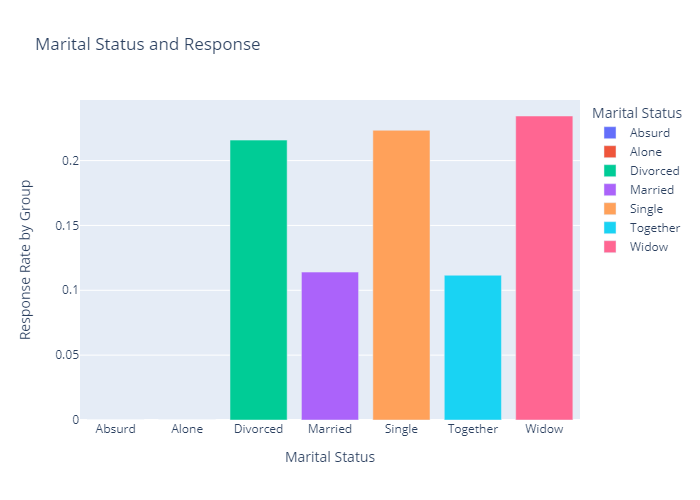

In [211]:
px.bar(train.groupby('marital_status').mean().reset_index(),
    x = 'marital_status',
    y = 'response',
    color = 'marital_status',
    title= 'Marital Status and Response',
    labels = {'response':"Response Rate by Group",
                "marital_status":"Marital Status"}
    ).show('png')


In [28]:
train['marital_status'].value_counts()

# drop alone and absurd??

Married     684
Together    466
Single      385
Divorced    190
Widow        64
Alone         2
Absurd        1
Name: marital_status, dtype: int64

## Trying out a few different estimators

### Baseline Dummy Model
- imputes missing income data but otherwise does 0 preprocessing

In [8]:
cat_features = ['education','marital_status']
num_features = X_train.select_dtypes(include=[np.number]).columns

In [9]:
cat_processor = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_processor = make_pipeline(
    SimpleImputer(strategy = 'median')
)

preprocessing = make_column_transformer(
    (cat_processor, cat_features),
    (num_processor, num_features)

)

baseline = make_pipeline(preprocessing, DummyClassifier())
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_train)

print('Baseline Accuracy score:')
print(baseline.score(X_train, y_train))
print('-----------')
print("Baseline confusion matrix:")
print(confusion_matrix(y_train, base_pred))
print('-----------')
print("Baseline model 5 fold Cross Val Accuracy scores")
print(cross_val_score(baseline, X_train, y_train, cv = 5, scoring = 'accuracy'))

Baseline Accuracy score:
0.8482142857142857
-----------
Baseline confusion matrix:
[[1520    0]
 [ 272    0]]
-----------
Baseline model 5 fold Cross Val Accuracy scores
[0.84679666 0.84679666 0.84916201 0.84916201 0.84916201]


### Preprocessing for candidate models

Build the preprocessors

In [10]:
cat_processor = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

log_processor = make_pipeline(
    SimpleImputer(strategy = 'median'),
    FunctionTransformer(np.log1p),
    StandardScaler()
)

default_num_processor = make_pipeline(
    SimpleImputer(strategy = 'median'),
    StandardScaler()
)

log_features = train.columns[train.columns.str.startswith('mnt') == True].to_list()

preprocessing_plus = ColumnTransformer(
    [
    ('cat', cat_processor, make_column_selector(dtype_include = 'object')),
    ('log', log_processor, log_features)
    ], remainder= default_num_processor)


Examine the output of the preprocessor

In [11]:
train_t = preprocessing_plus.fit_transform(X_train)
train_t = pd.DataFrame(data = train_t)
train_t.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.833469,1.309445,1.416689,1.241608,0.202348,1.218272,-1.479861,1.341123,-0.823738,-0.935875,0.376934,-0.692313,-0.039402,0.455044,1.32372,-1.816412,-0.097865
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.238118,0.999700,0.352451,0.952296,0.985575,0.533881,1.038094,1.634434,-0.823738,-0.935875,-0.770280,-0.692313,0.681083,1.473917,1.63547,-1.397600,-0.097865
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.356628,0.413056,1.213934,0.405981,0.827055,-0.174961,-1.144133,1.079849,-0.823738,-0.935875,-1.117920,-0.692313,0.320841,1.134292,-0.23503,-1.397600,-0.097865
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.379639,-0.290318,-0.490504,-0.261278,-0.103893,0.480508,-0.304815,-0.358346,-0.823738,0.893010,0.828867,-0.692313,-0.039402,-0.563830,0.07672,-0.141162,-0.097865
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.071815,0.718401,0.575754,0.454596,0.036858,0.730205,0.030912,0.670779,-0.823738,0.893010,1.072215,-0.174955,0.681083,1.813541,1.32372,-0.559975,-0.097865


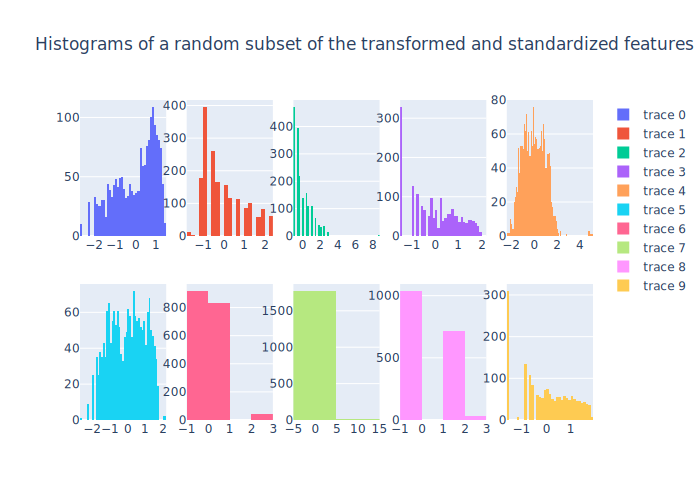

In [14]:
numeric_cols = np.arange(12,29)
cols_to_plot = np.random.choice(numeric_cols, size = 10, replace = False)
row_assn = np.array((1,1,1,1,1,2,2,2,2,2))
col_assn = np.array((1,2,3,4,5,1,2,3,4,5))
identifiers = np.column_stack((cols_to_plot,row_assn,col_assn)).tolist()

fig  = make_subplots(rows = 2, 
    cols = 5#,
    #subplot_titles = ('mntmeatproducts', 'mntwines', 'numcatalogpurchases', 'recency', 'income', 'teenhome', 'numwebpurchases', 'mntsweetproducts')
)

for i,j,k in identifiers:
    hist = go.Histogram(x = train_t[i])
    fig.append_trace(hist,j,k)

fig.update_layout(title_text = 'Histograms of a random subset of the transformed and standardized features <br> <sup> -Decent but not great, certainly dont all look like normal distribs</sup>')
fig.show('svg')

### SGD Linear SVM

In [15]:
from sklearn.linear_model import SGDClassifier

linearsvm = make_pipeline(preprocessing, SGDClassifier(loss = 'hinge'))     # 'hinge' means linear SVM 
linearsvm.fit(X_train, y_train)
linearsvm_pred = linearsvm.predict(X_train)

print('linearsvm Accuracy score:')
print(linearsvm.score(X_train, y_train))
print('-----------')
print("linearsvm confusion matrix:")
print(confusion_matrix(y_train, linearsvm_pred))
print('-----------')
print("linearsvm model 5 fold Cross Val Accuracy scores")
print(cross_val_score(linearsvm, X_train, y_train, cv = 5, scoring = 'accuracy'))


linearsvm Accuracy score:
0.8515625
-----------
linearsvm confusion matrix:
[[1494   26]
 [ 240   32]]
-----------
linearsvm model 5 fold Cross Val Accuracy scores
[0.84679666 0.84679666 0.84916201 0.8547486  0.8603352 ]


### Polynomial Kernel SVM

In [16]:
from sklearn.svm import SVC

kernelsvm = make_pipeline(preprocessing_plus, SVC(kernel = 'poly'))
kernelsvm.fit(X_train, y_train)
kernelsvm_pred = kernelsvm.predict(X_train)

print('kernelsvm Accuracy score:')
print(kernelsvm.score(X_train, y_train))
print('-----------')
print("kernelsvm confusion matrix:")
print(confusion_matrix(y_train, kernelsvm_pred))
print('-----------')
print("kernelsvm model 5 fold Cross Val Accuracy scores")
print(cross_val_score(kernelsvm, X_train, y_train, cv = 5, scoring = 'accuracy'))


kernelsvm Accuracy score:
0.9029017857142857
-----------
kernelsvm confusion matrix:
[[1508   12]
 [ 162  110]]
-----------
kernelsvm model 5 fold Cross Val Accuracy scores
[0.87465181 0.84958217 0.8547486  0.86312849 0.87709497]


In [ ]:
# use the below to get the name of every hyperparamter in you estimator
# kernelsvm.get_params().keys()

#### Hyperparameter tuning the Polynomial Kernel Support Vector Machine
Common hyperparamters to try:
- C: regularization paramter, strcitly positive. strength of reg is inversely proportional to c
- degree: degree of the polynomial kernel, default is 3, strictly positive
- coef0: controls how much the model is inflenced by high degree terms versus low degree terms 


In [126]:
### Iteration 1
kernelsmv_param_distribs = {'svc__C':randint(1,100),
                        'svc__degree': randint(1,5),
                        'svc__coef0':randint(1,10)}

rnd_search = RandomizedSearchCV(
    kernelsvm, 
    param_distributions = kernelsmv_param_distribs, 
    n_iter = 15, 
    scoring = 'accuracy', 
    random_state = 324
    )

rnd_search.fit(X_train, y_train)
print("Best hyperparameter combination:",rnd_search.best_params_)

rnd_search_results = pd.DataFrame(rnd_search.cv_results_)
rnd_search_results.sort_values(by = 'mean_test_score', ascending = False, inplace=True)
rnd_search_results

Best hyperparameter combination: {'svc__C': 89, 'svc__coef0': 1, 'svc__degree': 1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__coef0,param_svc__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.235328,0.057109,0.020145,0.009513,89,1,1,"{'svc__C': 89, 'svc__coef0': 1, 'svc__degree': 1}",0.846797,0.857939,0.857542,0.849162,0.849162,0.852120,0.004671,1
0,0.136123,0.028377,0.023825,0.007043,26,5,1,"{'svc__C': 26, 'svc__coef0': 5, 'svc__degree': 1}",0.846797,0.849582,0.857542,0.849162,0.849162,0.850449,0.003680,2
3,0.312174,0.041300,0.013297,0.001642,32,2,2,"{'svc__C': 32, 'svc__coef0': 2, 'svc__degree': 2}",0.857939,0.849582,0.840782,0.840782,0.835196,0.844856,0.008000,3
9,0.169517,0.027965,0.014171,0.000721,57,2,4,"{'svc__C': 57, 'svc__coef0': 2, 'svc__degree': 4}",0.830084,0.824513,0.854749,0.843575,0.849162,0.840416,0.011416,4
7,0.300105,0.087175,0.014577,0.000470,47,1,2,"{'svc__C': 47, 'svc__coef0': 1, 'svc__degree': 2}",0.855153,0.846797,0.843575,0.826816,0.824022,0.839273,0.011959,5
11,0.439843,0.087803,0.014371,0.002403,45,2,2,"{'svc__C': 45, 'svc__coef0': 2, 'svc__degree': 2}",0.857939,0.846797,0.840782,0.826816,0.821229,0.838712,0.013315,6
8,0.291729,0.021149,0.015577,0.003116,39,4,4,"{'svc__C': 39, 'svc__coef0': 4, 'svc__degree': 4}",0.832869,0.818942,0.843575,0.840782,0.837989,0.834831,0.008697,7
6,0.506462,0.074007,0.014784,0.001603,17,4,3,"{'svc__C': 17, 'svc__coef0': 4, 'svc__degree': 3}",0.827298,0.835655,0.837989,0.824022,0.837989,0.832591,0.005815,8
12,0.363276,0.030525,0.014744,0.001501,90,5,4,"{'svc__C': 90, 'svc__coef0': 5, 'svc__degree': 4}",0.827298,0.818942,0.840782,0.832402,0.829609,0.829807,0.007093,9
10,0.542502,0.043227,0.014221,0.001840,13,7,4,"{'svc__C': 13, 'svc__coef0': 7, 'svc__degree': 4}",0.827298,0.821727,0.840782,0.837989,0.821229,0.829805,0.008155,10


In [17]:
### Iteration 2
kernelsmv_param_distribs = {'svc__C':randint(50,100),
                        'svc__degree': randint(1,4),
                        'svc__coef0':randint(1,6)}

rnd_search = RandomizedSearchCV(
    kernelsvm, 
    param_distributions = kernelsmv_param_distribs, 
    n_iter = 15, 
    scoring = 'accuracy', 
    random_state = 324
    )

rnd_search.fit(X_train, y_train)
print("Best hyperparameter combination:",rnd_search.best_params_)

rnd_search_results = pd.DataFrame(rnd_search.cv_results_)
rnd_search_results.sort_values(by = 'mean_test_score', ascending = False, inplace=True)
rnd_search_results

Best hyperparameter combination: {'svc__C': 90, 'svc__coef0': 4, 'svc__degree': 1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__coef0,param_svc__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,1.012300,1.180964,0.017630,0.001337,90,4,1,"{'svc__C': 90, 'svc__coef0': 4, 'svc__degree': 1}",0.846797,0.857939,0.857542,0.849162,0.849162,0.852120,0.004671,1
14,0.191299,0.033547,0.018350,0.006603,87,2,1,"{'svc__C': 87, 'svc__coef0': 2, 'svc__degree': 1}",0.846797,0.857939,0.857542,0.849162,0.849162,0.852120,0.004671,1
0,0.983089,1.313607,0.018331,0.002948,75,5,1,"{'svc__C': 75, 'svc__coef0': 5, 'svc__degree': 1}",0.846797,0.855153,0.857542,0.849162,0.849162,0.851563,0.004071,3
1,0.178374,0.028956,0.016558,0.001012,74,1,1,"{'svc__C': 74, 'svc__coef0': 1, 'svc__degree': 1}",0.846797,0.855153,0.857542,0.849162,0.849162,0.851563,0.004071,3
7,0.159942,0.009757,0.016581,0.001857,58,4,1,"{'svc__C': 58, 'svc__coef0': 4, 'svc__degree': 1}",0.846797,0.855153,0.857542,0.849162,0.849162,0.851563,0.004071,3
8,0.401114,0.457390,0.015935,0.002617,69,4,1,"{'svc__C': 69, 'svc__coef0': 4, 'svc__degree': 1}",0.846797,0.855153,0.857542,0.849162,0.849162,0.851563,0.004071,3
9,0.394628,0.385494,0.017929,0.003024,71,4,1,"{'svc__C': 71, 'svc__coef0': 4, 'svc__degree': 1}",0.846797,0.855153,0.857542,0.849162,0.849162,0.851563,0.004071,3
11,1.247118,0.323550,0.016167,0.003474,65,5,2,"{'svc__C': 65, 'svc__coef0': 5, 'svc__degree': 2}",0.852368,0.838440,0.835196,0.826816,0.832402,0.837044,0.008560,8
6,1.091008,0.290566,0.019735,0.009973,62,4,2,"{'svc__C': 62, 'svc__coef0': 4, 'svc__degree': 2}",0.849582,0.844011,0.837989,0.824022,0.829609,0.837043,0.009290,9
5,0.906101,0.289298,0.015221,0.001843,70,3,2,"{'svc__C': 70, 'svc__coef0': 3, 'svc__degree': 2}",0.852368,0.835655,0.835196,0.826816,0.829609,0.835928,0.008875,10


In [18]:
tuned_ksvm = rnd_search.best_estimator_

### Logistic Regression 

In [28]:
from sklearn.linear_model import LogisticRegression

logreg = make_pipeline(preprocessing_plus, LogisticRegression(solver = 'liblinear'))
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_train)

print('logreg Accuracy score:')
print(logreg.score(X_train, y_train))
print('-----------')
print("logreg confusion matrix:")
print(confusion_matrix(y_train, logreg_pred))
print('-----------')
print("logreg model 5 fold Cross Val Accuracy scores")
print(cross_val_score(logreg, X_train, y_train, cv = 5, scoring = 'accuracy'))


logreg Accuracy score:
0.8699776785714286
-----------
logreg confusion matrix:
[[1479   41]
 [ 192   80]]
-----------
logreg model 5 fold Cross Val Accuracy scores
[0.88300836 0.83286908 0.8603352  0.86592179 0.8603352 ]


#### Hyperparameter tuning the logistic regression 
Common hyperparameters to try:
- penalty: default is the 'l2' norm, could also try 'l1' norm, None for no regularization, or 'elasticnet' for both l1 and l2
- C: inverse of the regularization strength, must be a positive float. Smaller values --> stronger regularization 

In [33]:
#logreg.get_params().keys()

In [34]:
### Iteration 2
logreg_param_distribs = {'logisticregression__C':randint(50,100),
                        'logisticregression__penalty': ['l1','l2']}

rnd_search = RandomizedSearchCV(
    logreg, 
    param_distributions = logreg_param_distribs, 
    n_iter = 15, 
    scoring = 'accuracy', 
    random_state = 324
    )

rnd_search.fit(X_train, y_train)
print("Best hyperparameter combination:",rnd_search.best_params_)

rnd_search_results = pd.DataFrame(rnd_search.cv_results_)
rnd_search_results.sort_values(by = 'mean_test_score', ascending = False, inplace=True)
rnd_search_results

KeyboardInterrupt: 

In [ ]:
tuned_logreg = rnd_search.best_estimator_

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfclassifier = make_pipeline(preprocessing_plus, RandomForestClassifier())
rfclassifier.fit(X_train, y_train)
rfclassifier_pred = rfclassifier.predict(X_train)

print('rfclassifier Accuracy score:')
print(rfclassifier.score(X_train, y_train))
print('-----------')
print("rfclassifier confusion matrix:")
print(confusion_matrix(y_train, rfclassifier_pred))
print('-----------')
print("rfclassifier model 5 fold Cross Val Accuracy scores")
print(cross_val_score(rfclassifier, X_train, y_train, cv = 5, scoring = 'accuracy'))


rfclassifier Accuracy score:
0.9944196428571429
-----------
rfclassifier confusion matrix:
[[1518    2]
 [   8  264]]
-----------
rfclassifier model 5 fold Cross Val Accuracy scores
[0.85236769 0.86629526 0.8575419  0.87988827 0.87709497]


In [ ]:
cross_val_score(rfclassifier, X_train, y_train, cv = 5, scoring = 'accuracy')

array([0.84958217, 0.86629526, 0.87150838, 0.86871508, 0.87430168])

#### Hyperparameter tuning the random forest

In [ ]:
# rfclassifier.get_params().keys()

In [ ]:
rfcl_param_distribs = {'randomforestclassifier__n_estimators':randint(50,250),
                        'randomforestclassifier__min_samples_split': randint(2,10),
                        'randomforestclassifier__min_samples_leaf':randint(1,10)}

rnd_search = RandomizedSearchCV(
    rfclassifier, 
    param_distributions = rfcl_param_distribs, 
    n_iter = 15, 
    scoring = 'accuracy', 
    random_state = 324
    )

rnd_search.fit(X_train, y_train)
print("Best hyperparameter combination:", rnd_search.best_params_)

rnd_search_results = pd.DataFrame(rnd_search.cv_results_)
rnd_search_results.sort_values(by = 'mean_test_score', ascending = False, inplace=True)
rnd_search_results

Best hyperparameter combination: {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 169}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.577108,0.053038,0.040401,0.004516,1,2,169,{'randomforestclassifier__min_samples_leaf': 1...,0.857939,0.857939,0.871508,0.882682,0.879888,0.869991,0.010505,1
6,0.395546,0.009187,0.030432,0.001332,2,6,141,{'randomforestclassifier__min_samples_leaf': 2...,0.857939,0.855153,0.874302,0.877095,0.879888,0.868875,0.010259,2
4,0.267420,0.008435,0.024532,0.003438,2,3,84,{'randomforestclassifier__min_samples_leaf': 2...,0.860724,0.857939,0.877095,0.865922,0.879888,0.868314,0.008741,3
11,0.628696,0.095115,0.043214,0.007203,2,9,190,{'randomforestclassifier__min_samples_leaf': 2...,0.857939,0.855153,0.874302,0.874302,0.871508,0.866641,0.008352,4
13,0.436816,0.058978,0.032329,0.006654,2,7,139,{'randomforestclassifier__min_samples_leaf': 2...,0.852368,0.863510,0.865922,0.879888,0.868715,0.866081,0.008857,5
9,0.262770,0.004670,0.021154,0.001474,1,7,88,{'randomforestclassifier__min_samples_leaf': 1...,0.855153,0.852368,0.868715,0.874302,0.874302,0.864968,0.009417,6
3,0.629303,0.013282,0.043105,0.002943,1,9,203,{'randomforestclassifier__min_samples_leaf': 1...,0.855153,0.855153,0.868715,0.874302,0.871508,0.864966,0.008205,7
8,0.374963,0.065535,0.036719,0.018180,4,8,96,{'randomforestclassifier__min_samples_leaf': 4...,0.852368,0.846797,0.871508,0.871508,0.868715,0.862179,0.010485,8
5,0.527472,0.072464,0.059455,0.035807,5,8,164,{'randomforestclassifier__min_samples_leaf': 5...,0.866295,0.852368,0.863128,0.863128,0.863128,0.861610,0.004781,9
14,0.453204,0.022600,0.038855,0.013701,5,9,159,{'randomforestclassifier__min_samples_leaf': 5...,0.844011,0.860724,0.860335,0.874302,0.865922,0.861059,0.009902,10


In [39]:
rfcl_param_distribs = {'randomforestclassifier__n_estimators':randint(80,200),
                        'randomforestclassifier__min_samples_split': randint(2,8),
                        'randomforestclassifier__min_samples_leaf':randint(1,6)}

rnd_search = RandomizedSearchCV(
    rfclassifier, 
    param_distributions = rfcl_param_distribs, 
    n_iter = 15, 
    scoring = 'accuracy', 
    random_state = 324
    )

rnd_search.fit(X_train, y_train)
print("Best hyperparameter combination:", rnd_search.best_params_)

rnd_search_results = pd.DataFrame(rnd_search.cv_results_)
rnd_search_results.sort_values(by = 'mean_test_score', ascending = False, inplace=True)
rnd_search_results

Best hyperparameter combination: {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 120}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.387927,0.023964,0.028818,0.001463,1,2,120,{'randomforestclassifier__min_samples_leaf': 1...,0.852368,0.860724,0.877095,0.877095,0.882682,0.869993,0.011476,1
4,0.575630,0.011852,0.036761,0.001198,2,3,193,{'randomforestclassifier__min_samples_leaf': 2...,0.857939,0.863510,0.877095,0.879888,0.863128,0.868312,0.008587,2
9,0.288376,0.010082,0.025806,0.004242,4,2,101,{'randomforestclassifier__min_samples_leaf': 4...,0.863510,0.855153,0.868715,0.874302,0.868715,0.866079,0.006442,3
11,0.236375,0.003934,0.022465,0.001915,3,6,81,{'randomforestclassifier__min_samples_leaf': 3...,0.863510,0.860724,0.857542,0.868715,0.877095,0.865517,0.006854,4
0,0.418641,0.106703,0.032523,0.014280,2,6,92,{'randomforestclassifier__min_samples_leaf': 2...,0.855153,0.855153,0.865922,0.871508,0.874302,0.864408,0.008024,5
10,0.387019,0.008556,0.028655,0.001922,4,5,136,{'randomforestclassifier__min_samples_leaf': 4...,0.852368,0.860724,0.863128,0.877095,0.868715,0.864406,0.008242,6
14,0.345365,0.008428,0.026714,0.001586,3,3,117,{'randomforestclassifier__min_samples_leaf': 3...,0.860724,0.852368,0.865922,0.871508,0.871508,0.864406,0.007234,6
6,0.505734,0.080603,0.036586,0.010751,3,3,156,{'randomforestclassifier__min_samples_leaf': 3...,0.855153,0.855153,0.865922,0.874302,0.868715,0.863849,0.007596,8
7,0.425243,0.005954,0.032727,0.002385,4,3,152,{'randomforestclassifier__min_samples_leaf': 4...,0.855153,0.857939,0.863128,0.868715,0.871508,0.863289,0.006194,9
3,0.344262,0.037919,0.027065,0.002379,4,2,111,{'randomforestclassifier__min_samples_leaf': 4...,0.857939,0.857939,0.863128,0.868715,0.868715,0.863287,0.004820,10


In [40]:
tuned_rfc = rnd_search.best_estimator_

## Comparing performance across the estimators

### Define a function to grab most relevant stas of each estimator using cross validation

In [36]:
def classification_cv_metrics(model, X_train, y_train, cv, method, model_name):
    # model is the same thing as estimator
    # method will likely either be 'decision_function' or 'predict_proba' depending on the estimator
    # model_name is how the model will appear in downstream datasets of performance scores across all models

    # Obtain cross validation scores
    y_scores = cross_val_predict(estimator = model, X = X_train, y = y_train, cv = cv, method = method)

    # Depending on the estimator the scores output may be mutlidimensional, for example random forest predict_proba returns 2 probabilities for each instance
    if y_scores.ndim > 1:
        y_scores_mod = y_scores[:,1]
    else:
        y_scores_mod = y_scores

    # create a dataframe for precision and recall 
    precision, recall, threshold = precision_recall_curve(y_train, y_scores_mod)
    pr_data = {'model':model_name, 'precision':precision[:-1], 'recall':recall[:-1], 'threshold':threshold}
    pr_wide = pd.DataFrame(pr_data)
    pr_long = pr_wide.melt(id_vars = ['threshold','model'])

    # create dataframes for ROC curve TPR (recall, sensitivity) and FPR (Fallout, 1 - specificity)
    fpr, tpr, threshold = roc_curve(y_train, y_scores_mod)
    roc_data = {'model':model_name,'fpr':fpr,'tpr':tpr,'threshold':threshold}
    roc_wide = pd.DataFrame(roc_data)
    roc_long = roc_wide.melt(id_vars = ['threshold','model'])

    # save out the scores for later
    scores = pd.Series(y_scores_mod, name = model_name)

    return(pr_wide, pr_long, roc_wide, roc_long, scores)


### Run all the models through the cross val function defined above

In [41]:
base_prw, base_prl, base_rocw, base_rocl, base_scores = classification_cv_metrics(model=baseline, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'predict_proba',
    model_name = 'base')

lsvm_prw, lsvm_prl, lsvm_rocw, lsvm_rocl, lsvm_scores = classification_cv_metrics(model=linearsvm, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'decision_function',
    model_name = 'lsvm')

ksvm_prw, ksvm_prl, ksvm_rocw, ksvm_rocl, ksvm_scores = classification_cv_metrics(model=kernelsvm, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'decision_function',
    model_name = 'ksvm')

tuned_ksvm_prw, tuned_ksvm_prl, tuned_ksvm_rocw, tuned_ksvm_rocl, tuned_ksvm_scores = classification_cv_metrics(model=tuned_ksvm, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'decision_function',
    model_name = 'tuned_ksvm')

logr_prw, logr_prl, logr_rocw, logr_rocl, logr_scores = classification_cv_metrics(model=logreg, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'predict_proba',
    model_name = 'logr')

tuned_logr_prw, tuned_logr_prl, tuned_logr_rocw, tuned_logr_rocl, tuned_logr_scores = classification_cv_metrics(model=tuned_logreg, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'predict_proba',
    model_name = 'tuned_logr')  

rfcl_prw, rfcl_prl, rfcl_rocw, rfcl_rocl, rfcl_scores = classification_cv_metrics(model=rfclassifier, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'predict_proba',
    model_name = 'rfcl')

tuned_rfc_prw, tuned_rfc_prl, tuned_rfc_rocw, tuned_rfc_rocl, tuned_rfc_scores = classification_cv_metrics(model=tuned_rfc, 
    X_train = X_train, 
    y_train = y_train, 
    cv = 3, 
    method = 'predict_proba',
    model_name = 'tuned_rfc')

Combine the results

In [42]:

# Generate wide datasets of all models' precision and recall scores
models_prw = pd.concat([base_prw,lsvm_prw, ksvm_prw, rfcl_prw, tuned_ksvm_prw, logr_prw, tuned_logr_prw, tuned_rfc_prw], ignore_index = True)
models_prl = pd.concat([base_prl,lsvm_prl, ksvm_prl, rfcl_prl, tuned_ksvm_prl, logr_prl, tuned_logr_prl, tuned_rfc_prl], ignore_index = True)

# generate long datasets of all models' reciever operator characteristics
models_rocw = pd.concat([base_rocw,lsvm_rocw, ksvm_rocw, rfcl_rocw, tuned_ksvm_rocw, logr_rocw, tuned_logr_rocw, tuned_rfc_rocw], ignore_index = True)
models_rocl = pd.concat([base_rocl,lsvm_rocl, ksvm_rocl, rfcl_rocl, tuned_ksvm_rocl, logr_rocl, tuned_logr_rocl, tuned_rfc_rocl], ignore_index = True)

# generate a dataframe of model scores for the training data
model_scores = pd.concat([base_scores,lsvm_scores,ksvm_scores,rfcl_scores,tuned_ksvm_scores,logr_scores, tuned_logr_scores, tuned_rfc_scores], axis = 1, ignore_index = True)


### Plots of performance across models

Precision and Recall by threshold faceted by model

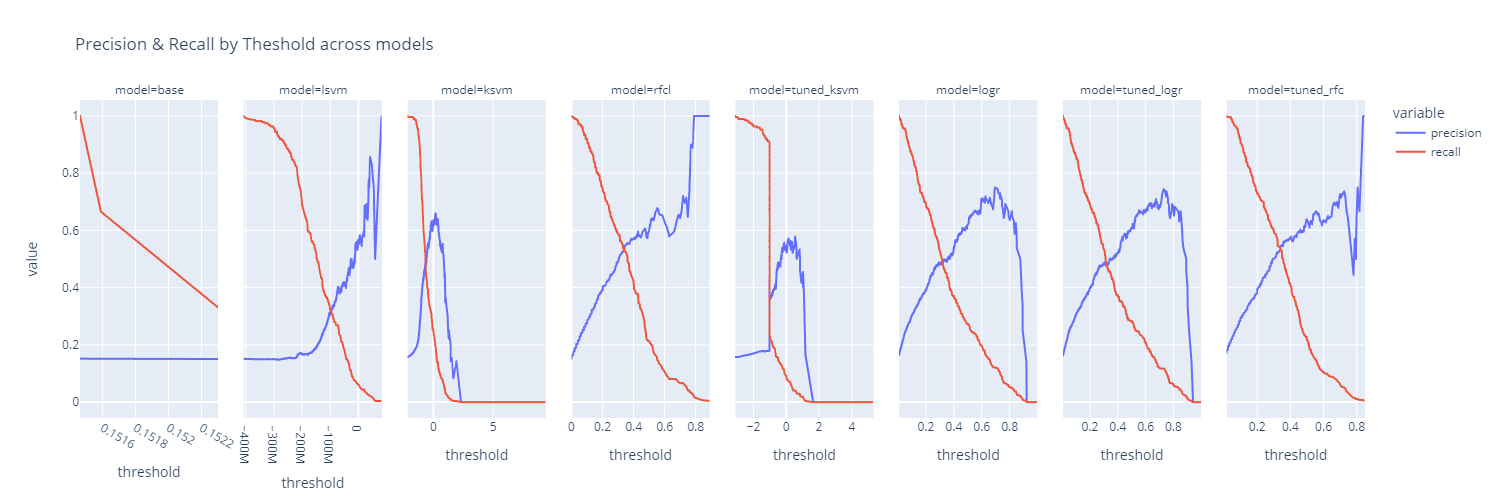

In [43]:
fig = px.line(models_prl, 
    x = 'threshold', 
    y = 'value', 
    color = 'variable',
    facet_col = 'model',
    title = 'Precision & Recall by Theshold across models',
    width = 1500)
    
fig.update_xaxes(matches = None)
fig.show('png')

Precision vs. recall curves for all models

In [47]:
px.line(models_prw, 
    x = 'recall',
    y = 'precision',
    color = 'model',
    title = 'Precision vs Recall Curve across models',
    height = 600,
    width = 900).show('png')

ROC curves for all models

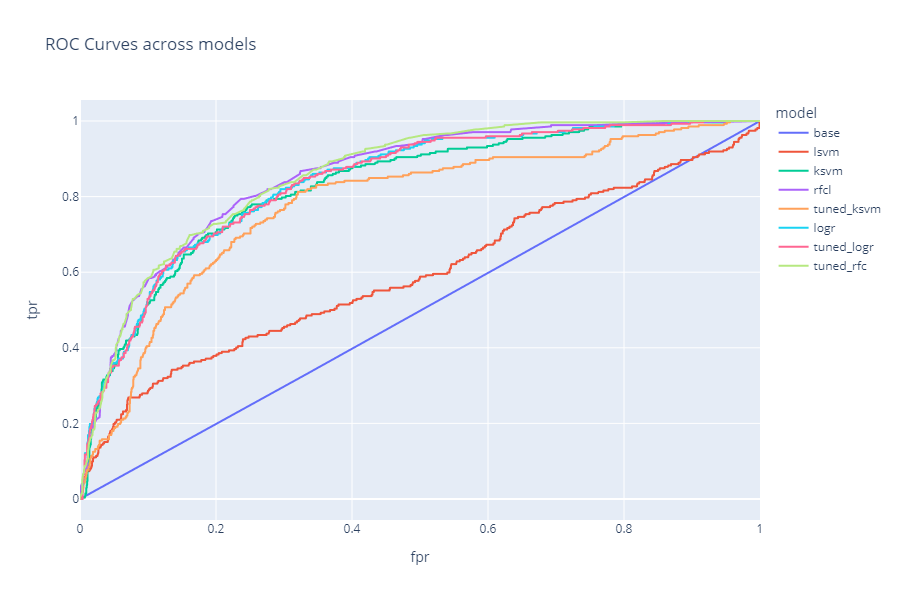

In [49]:
px.line(models_rocw,
    x = 'fpr',
    y = 'tpr',
    color = 'model',
    title = 'ROC Curves across models',
    height = 600,
    width = 900).show('png')

## Choosing a threshold for the winning model
Supose we want 85% recall. Which model has the highest precision for this recall?

In [201]:
# select the highest precisions per model where recall is at or above 85%
models_prw.query("recall >= .8500").groupby('model')['precision'].nlargest(3)

model           
base        0       0.151786
ksvm        2670    0.296296
            2666    0.296061
            2669    0.295918
logr        6254    0.311409
            6250    0.311081
            6253    0.310992
lsvm        266     0.155263
            265     0.155161
            252     0.155150
rfcl        3512    0.323731
            3511    0.323288
            3513    0.323246
tuned_ksvm  4476    0.252174
            4475    0.251900
            4474    0.251627
tuned_logr  7879    0.310992
            7878    0.310576
            7877    0.310160
tuned_rfc   8692    0.318306
            8691    0.317439
            8690    0.316576
Name: precision, dtype: float64

In [202]:
index_of_chosen_recall = models_prw.query("recall >= .8500")['precision'].idxmax()
threshold = models_prw['threshold'].iloc[index_of_chosen_recall]
models_prw.iloc[index_of_chosen_recall,:]

model            rfcl
precision    0.323731
recall       0.867647
threshold       0.135
Name: 3512, dtype: object

In [203]:
predictions = (tuned_rfc_scores >= threshold)
print(recall_score(y_train, predictions))
print(precision_score(y_train, predictions))

0.8382352941176471
0.32248939179632247


## Inspection of chosen model's errors 
- Does the model perform equally well across categories?
- Are there systematic ways in which the model makes errors?

Note that the index on the prediction vector will not match the training set and this must be resolved

In [204]:
train_plus = train.copy()
train_plus['pred'] = predictions.values
train_plus['response_bool'] = train_plus['response'].astype(bool)
train_plus.head()

,year_birth,education,marital_status,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain,pred,response_bool
1356,1951,Graduation,Single,80872.0,0,0,60,483,72,567,94,12,108,1,4,4,10,1,0,0,False,False
629,1981,PhD,Married,87171.0,0,0,27,1001,44,107,58,44,44,1,6,7,11,2,0,0,True,False
402,1955,PhD,Together,75261.0,0,0,17,1239,17,413,23,34,17,1,5,6,5,2,1,0,True,True
1645,1965,Graduation,Married,44375.0,0,1,73,213,5,28,7,7,41,1,4,1,6,5,0,0,False,False
1801,1969,Master,Together,66476.0,0,1,80,742,28,152,25,9,57,2,6,8,10,4,0,0,False,False


Verify that the predictions line up with training as expected

In [205]:
print("Recall:", recall_score(train_plus.response, train_plus.pred))
print("Precision:", precision_score(train_plus.response, train_plus.pred))
pd.crosstab(train_plus['response_bool'],train_plus['pred'])


Recall: 0.8382352941176471
Precision: 0.32248939179632247


pred,False,True
response_bool,,
False,1041,479
True,44,228


### Is the model equally biased across categories for these types opf variables?

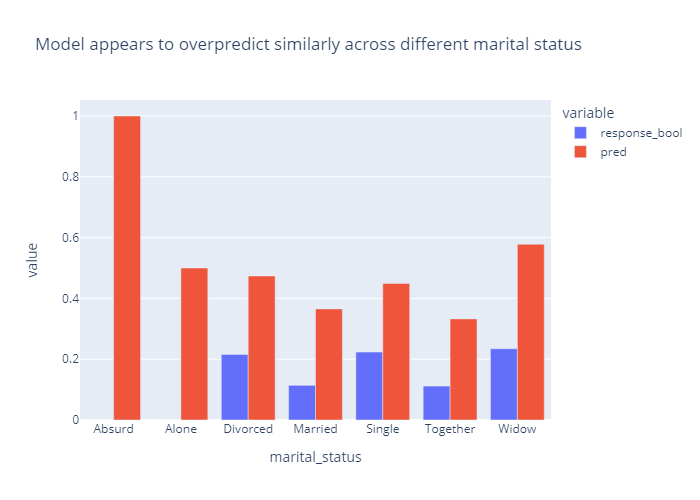

In [206]:
px.bar(train_plus.groupby('marital_status', as_index = False)[['response_bool','pred']].mean().melt(id_vars = 'marital_status'),
        x = 'marital_status',
        y = 'value',
        color = 'variable',
        barmode = 'group',
        title = 'Model appears to overpredict similarly across different marital status').show('png')

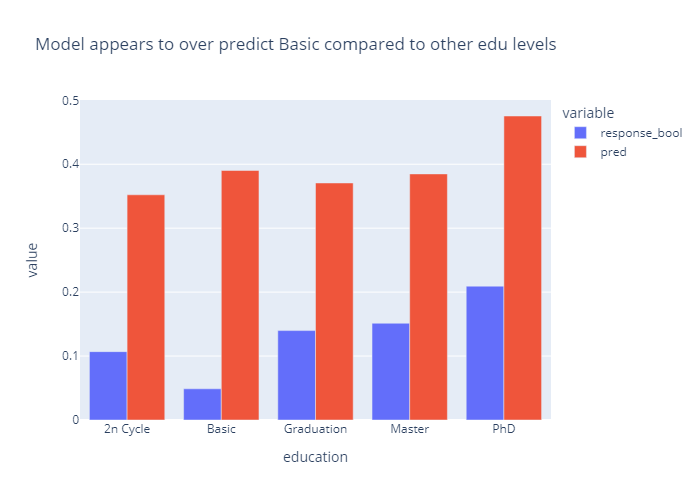

In [207]:
px.bar(train_plus.groupby('education', as_index = False)[['response_bool','pred']].mean().melt(id_vars = 'education'),
        x = 'education',
        y = 'value',
        color = 'variable',
        barmode = 'group',
        title = 'Model appears to over predict Basic compared to other edu levels').show('png')

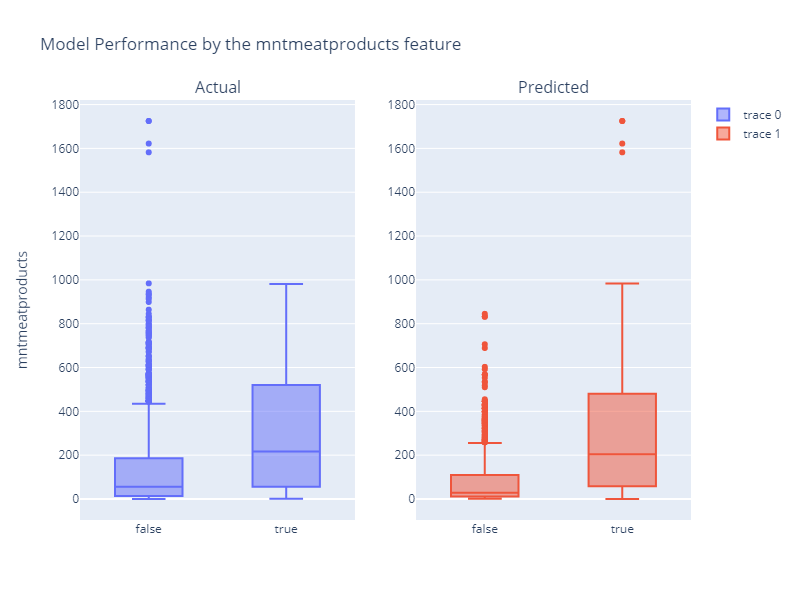

In [214]:
fig = make_subplots(rows=1, cols=2, subplot_titles = ("Actual",'Predicted'))

fig.add_trace(
    go.Box(x=train_plus.response_bool, y=train_plus.mntmeatproducts),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=train_plus.pred, y=train_plus.mntmeatproducts),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Model Performance by the mntmeatproducts feature")
fig.update_yaxes(title_text = 'mntmeatproducts', row = 1, col = 1)
fig.show('png')

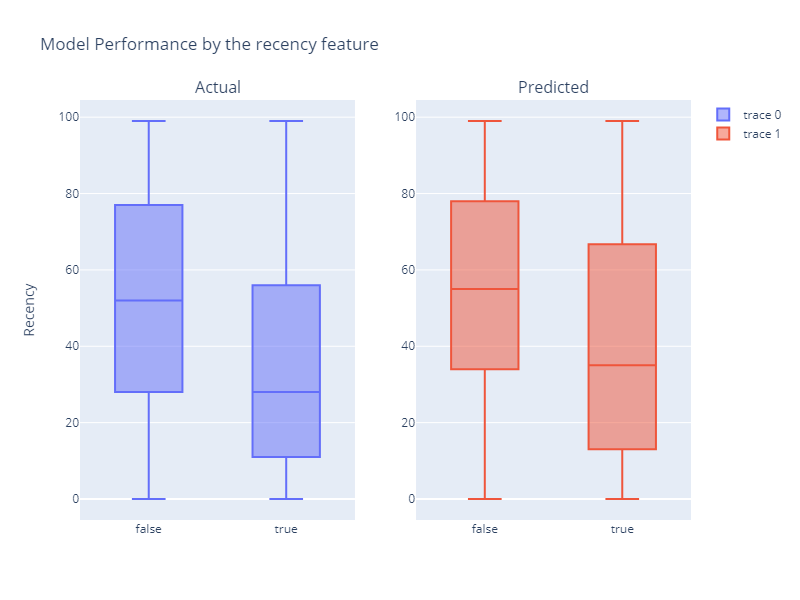

In [215]:
fig = make_subplots(rows=1, cols=2, subplot_titles = ("Actual",'Predicted'))

fig.add_trace(
    go.Box(x=train_plus.response_bool, y=train_plus.recency),
    row=1, col=1
)

fig.add_trace(
    go.Box(x=train_plus.pred, y=train_plus.recency),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Model Performance by the recency feature")
fig.update_yaxes(title_text = 'Recency', row = 1, col = 1)
fig.show('png')